In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
# import seaborn as sns
from pyik.mplext import ViolinPlot
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import sqlite3

from pyik.mplext import ViolinPlot
from util_general import QuickSlicePlot

In [ ]:
posts_path = "/home/alex/data/stackexchange/overflow/caches/posts.db"
meta_path = "/home/alex/data/stackexchange/overflow/caches/posts_2017.hdf5"
word_dict_path = "./dictionaries/words_2017.hdf5"
word_list_path = "./words/features_2017.hdf5"

In [ ]:
conn = sqlite3.connect(posts_path)

In [ ]:
store_meta = pd.HDFStore(meta_path, "r", complib="blosc", complevel=9)
store_dict = pd.HDFStore(word_dict_path, "r", complib="blosc", complevel=9)
store_feat = pd.HDFStore(word_list_path, "r", complib="blosc", complevel=9)

In [ ]:
del qs

In [ ]:
smask = store_meta.select_as_coordinates("posts", "PostTypeId == 1")
qs = store_meta.select("posts", where=smask)
qs.set_index("Id", inplace=True, drop=False)
print qs.shape

In [ ]:
answers = store_meta.select("posts", where=store_meta.select_as_coordinates("posts", "PostTypeId == 2"))
answers.set_index("Id", inplace=True, drop=False)
print answers.shape

In [ ]:
words = store_dict.select("all")

words["freqs"] = words.n * 1. / words.n.sum()
words = words.sort_values(by="n", ascending=False)
words["order"] = np.arange(1, words.shape[0] + 1)
# drop known nuisance words that made it into the list
words = words.drop(544765)
words = words.drop(430514)

In [ ]:
features = store_feat.select("words")
features.set_index("Id", inplace=True, drop=False)

In [ ]:
first = words.iloc[:20]
plt.figure(figsize=(8,6))
plt.xlabel(r"Word")
plt.ylabel(r"Percentage of occurrence")
plt.bar(np.arange(1, first.shape[0] + 1), first.n.values * 100. / words.n.sum(), 
        align="center", color="k", alpha=0.6)
plt.xticks(np.arange(1, first.shape[0] + 1), first.words.values, rotation=90)
plt.savefig("./plots/mostcommonwords.pdf")

In [ ]:
# did the number of answers change with time?
plt.figure(figsize=(8,6))
plt.xlabel(r"Number of answers to a question")
plt.ylabel("Normalized counts (a.u.)")
qs.AnswerCount.hist(range=[-0.5, 29.5], bins=30, color="r", normed=True, histtype="step", label="2017", axes=plt.gca())
plt.legend(loc="best")
plt.savefig("./plots/nanswers_time.pdf")

In [ ]:
qs.columns

In [ ]:
# convert to datetime objects
datecols = ["CreationDate"]
for datecol in datecols:
    qs[datecol] = pd.to_datetime(qs[datecol], origin="julian", unit="D")

In [ ]:
features

In [ ]:
# check a single (or multiple) posts
conn.execute("SELECT * FROM posts WHERE id=?", (158743,)).fetchall()

In [ ]:
# join in information about occurring words, probabilities etc
qs = qs.join(features, how="inner", rsuffix="_r")
qs.head()

In [ ]:
qs["Tags"] = qs.Tags.apply(lambda x: x.split(";")[1:])
qs["hasAnswers"] = qs.AnswerCount > 1

In [ ]:
# check available info
qs.columns

In [ ]:
now = pd.Timestamp.now()
print now

In [ ]:
qs["dt_created"] = now - qs.CreationDate

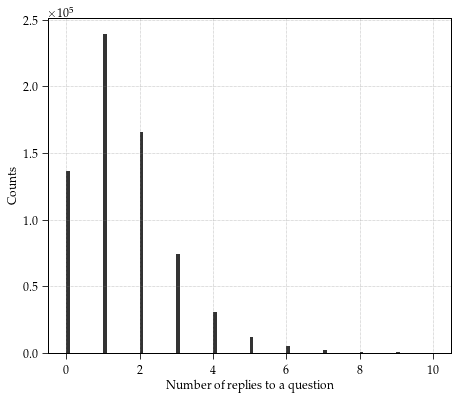

In [46]:
plt.figure(figsize=(8,6))
plt.xlabel(r"Number of replies to a question")
plt.ylabel(r"Counts")
qs.AnswerCount.hist(bins=100, range=(0, 10), color="k", alpha=0.8)
plt.savefig("./plots/naswers_hist.pdf")

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel(r"Days since a question was created")
plt.ylabel(r"Number of answers")
QuickSlicePlot(qs.dt_created.dt.days, qs.AnswerCount, qs.Score, zbins=1, xbins=10, 
               yrange=[0, 3], axes=plt.gca(), outliers=False)
plt.savefig("./plots/nanswers_vs_dt.pdf")

In [242]:
# cutting on too short questions because metrics are not working for those (yet)
qs = qs[qs.nwords > 5]

In [243]:
print len(qs)

668019


In [244]:
# shuffling the df to avoid time dependencies for now
from sklearn.utils import shuffle
qs = shuffle(qs)
print len(qs)

668019


In [ ]:
# join information about first answer into the frame
# RUN ONLY ONCE or results in duplicate rows
qs = qs.merge(answers, how="left", left_on="Id", right_on="ParentId", suffixes=("", "_a"))
print qs.head()

In [ ]:
qs["CreationDate_a"] = pd.to_datetime(qs.CreationDate_a, origin="julian", unit="D")

In [ ]:
# time between questions posing and first answer
dtanswer = qs.CreationDate_a - qs.CreationDate

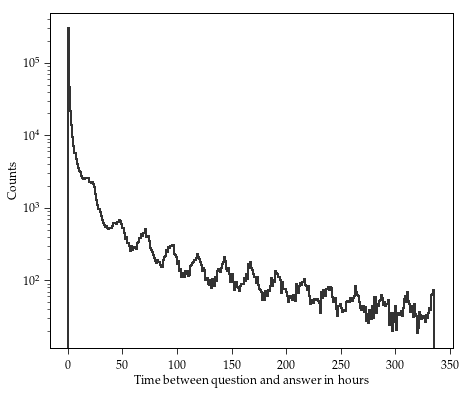

In [239]:
from pyik.fit import ChiSquareFunction
from pyik.numpyext import centers

dthours = dtanswer.dt.total_seconds() * 1. / 60 / 60
dtcont = np.linspace(0, 14 * 24, 1000)

counts, e = np.histogram(dthours, range=(0, 24 * 14), bins=24 * 14)
cens = centers(e)[0]

# print counts, cens

fitmodel = lambda dt, pars: 10 ** (pars[0] - dt * pars[1]) + 10 ** (pars[2] - dt * pars[3])
# fitmodel = lambda dt, pars: np.e ** pars[0] * dt ** pars[1]
chi2fct = ChiSquareFunction(fitmodel, counts, cens, yerrs=np.sqrt(counts))
#pars, cov, chi2, ndof = chi2fct.Minimize(np.asfarray([2, 0.1, 5.3, 0.13]), 
#                                         lower_bounds=np.asfarray([1, 0.01, 5, 0.05]),
#                                         upper_bounds=np.asfarray([3, 0.2, 6, 0.3]),
#                                         method="PRAXIS")

plt.figure(figsize=(8, 6))
plt.xlabel(r"Time between question and answer in hours")
plt.ylabel(r"Counts")
plt.hist(dthours, bins=24 * 14,
         color="k", alpha=0.8, range=(0, 14 * 24),
         histtype="step", lw=2)

#plt.plot(dtcont, fitmodel(dtcont, pars), "r-", lw=2)

plt.semilogy(nonposy="clip")
plt.savefig("./plots/dtanswer_hist.pdf")

In [164]:
pars

array([  2.14989868e+00,   5.78100914e-06,   5.20001677e+00,
         1.43188132e-01])

In [ ]:
# really, answer come so quick
qs[dtanswer.dt.total_seconds() < 60][["Id", "CreationDate", "CreationDate_a"]].head()

In [ ]:
QuickSlicePlot(qs.Score, dtanswer.dt.total_seconds() * 1. / 60 / 60, qs.AnswerCount, zbins=1, xbins=20, yrange=[0, 200])

In [299]:
# scikitlearn import
from sklearn import base
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from scipy import stats
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [247]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        return X[self.col_names]

In [270]:
from collections import Counter

class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_name):
        self.col_name = col_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        a = X[self.col_name].apply(Counter)
        return a

In [249]:
print len(qs)

668019


In [341]:
traincut = 300000
qs = shuffle(qs)
print len(qs)
 
# e.g. for regression
#labels = qs.AnswerCount

# e.g. classification, i.e. logistic regression
labels = qs.hasAnswers

668019


In [399]:
pipe_tags = Pipeline([
         ("cst", ColumnSelectTransformer(["Tags"])),
         ("dec", DictEncoder("Tags")),
         ("dvec", DictVectorizer(sparse=True)),
         ("tfid", TfidfTransformer()),
#        ("poly", PolynomialFeatures(degree=2)),  # not working???
#        ("ridge", Ridge(alpha=10.0))
         ("logi", LogisticRegression())
#        ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
#        ("svr", SVR())
    ])

pipe_tags.fit(qs.iloc[:traincut], labels.iloc[:traincut])
pred = pipe_tags.predict(qs.iloc[traincut:])
print np.column_stack((pred, labels.iloc[traincut:]))
print labels.iloc[traincut:].shape[0] * 1. / 2, labels.iloc[traincut:].shape[0]
print np.sum(pred == labels.iloc[traincut:])
print pipe_tags.score(qs.iloc[traincut:], labels.iloc[traincut:])

[[False  True]
 [False False]
 [False False]
 ..., 
 [False False]
 [False False]
 [ True  True]]
184009.5 368019
245743
0.667745415318


In [260]:
pipe_tags.named_steps["ridge"].get_params()

{'alpha': 10.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [344]:
qs.columns
qs.hot_indices.head()

224875     2;6;11;15;61;83;136;178;242;275;433;561;672;3644
434387    3;9;13;15;21;218;245;253;339;358;498;618;686;1...
22259     2;11;12;21;30;33;51;53;67;96;120;166;211;213;2...
311649    1;23;26;43;53;56;71;87;156;226;233;331;370;374...
392468               1;3;4;5;25;51;53;60;78;155;157;177;377
Name: hot_indices, dtype: object

In [398]:
pipe_words = Pipeline([
        ("cst", ColumnSelectTransformer(["hot_indices"])),
        ("dec", DictEncoder("hot_indices")),
        ("dvec", DictVectorizer(sparse=True)),
        ("tfid", TfidfTransformer()),
#        ("ridge", Ridge(alpha=1.0))
        ("logi", LogisticRegression())
    ])

pipe_words.fit(qs.iloc[:traincut], labels.iloc[:traincut])
pred = pipe_words.predict(qs.iloc[traincut:])
print np.column_stack((pred, labels.iloc[traincut:]))
print labels.iloc[traincut:].shape[0] * 1. / 2, labels.iloc[traincut:].shape[0]
print np.sum(pred == labels.iloc[traincut:])
print pipe_words.score(qs.iloc[traincut:], labels.iloc[traincut:])

[[False  True]
 [ True False]
 [False False]
 ..., 
 [False False]
 [False False]
 [False  True]]
184009.5 368019
209397
0.568984210054


In [ ]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

In [290]:
qs.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'Id_r',
       u'hot_indices', u'nwords', u'ordersum', u'prob_bern', u'prob_poiss',
       u'ratio', u'hasAnswers', u'dt_created', u'AcceptedAnswerId_a',
       u'AnswerCount_a', u'BodyNCodes_a', u'BodyNQMarks_a', u'BodySize_a',
       u'ClosedDate_a', u'CommentCount_a', u'CommunityOwnedDate_a',
       u'CreationDate_a', u'FavoriteCount_a', u'Id_a', u'LastActivityDate_a',
       u'LastEditDate_a', u'LastEditorUserId_a', u'OwnerUserId_a',
       u'ParentId_a', u'PostTypeId_a', u'Score_a', u'Tags_a', u'Title_a',
       u'ViewCount_a'],
      dtype='object')

In [346]:
qs["titlelen"] = qs["Title"].apply(len)

In [348]:
qs.columns
qs[["BodyNCodes", "BodyNQMarks", "BodySize", "nwords", "ratio",
                                         "prob_bern", "ordersum", "titlelen"]].head()

,BodyNCodes,BodyNQMarks,BodySize,nwords,ratio,prob_bern,ordersum,titlelen
224875,1,0,1366,22,0.266667,1.815438e-23,6319,138
434387,1,1,3176,33,0.611111,1.090123e-37,17431,32
22259,1,66,11160,56,0.393939,5.871084e-57,25936,50
311649,0,0,682,58,0.315789,7.922422e-61,31796,74
392468,2,1,536,16,0.555556,2.841112e-18,1146,34


In [349]:
cols = ["BodyNCodes", "BodyNQMarks", "BodySize", "nwords", "ratio", "prob_bern", "ordersum", "titlelen"]
# normalize columns
for col in cols:
    quants = qs[col].quantile([0.01, 0.99]).values
    print col, quants
    qs["%s_norm" % col] = (qs[col] - quants[0]) / (quants[1] - quants[0])

BodyNCodes [  0.  15.]
BodyNQMarks [  0.  10.]
BodySize [   165.    10486.64]
nwords [   7.  152.]
ratio [ 0.11111111  1.5       ]
prob_bern [  9.26546984e-82   1.74969467e-11]
ordersum [   941.    47263.64]
titlelen [  20.  119.]


In [350]:
qs[["BodyNCodes_norm", "BodyNQMarks_norm", "BodySize_norm", "nwords_norm", "ratio_norm",
                                         "prob_bern_norm", "ordersum_norm", "titlelen_norm"]].head()

,BodyNCodes_norm,BodyNQMarks_norm,BodySize_norm,nwords_norm,ratio_norm,prob_bern_norm,ordersum_norm,titlelen_norm
224875,0.066667,0.0,0.116357,0.103448,0.112000,1.037574e-12,0.116099,1.191919
434387,0.066667,0.1,0.291717,0.179310,0.360000,6.230361e-27,0.355981,0.121212
22259,0.066667,6.6,1.065238,0.337931,0.203636,3.355491e-46,0.539585,0.303030
311649,0.000000,0.0,0.050089,0.351724,0.147368,4.527889e-50,0.666089,0.545455
392468,0.133333,0.1,0.035944,0.062069,0.320000,1.623776e-07,0.004425,0.141414


In [368]:
qs["ordersum_norm_trafo"] = 1. / qs.ordersum_norm
qs["titlelen_norm_trafo"] = 1. / qs.titlelen_norm

In [397]:
labels = qs.hasAnswers

pipe_feat = Pipeline([
#        ("cst", ColumnSelectTransformer(["BodyNCodes_norm", "BodyNQMarks_norm", "BodySize_norm", "nwords_norm", "ratio_norm",
#                                         "prob_bern_norm", "ordersum_norm", "titlelen_norm"])),
         ("cst", ColumnSelectTransformer(["BodyNCodes_norm", "BodyNQMarks_norm", "nwords_norm", "BodySize_norm",
                                          "ratio_norm", "ordersum_norm", "titlelen_norm"])),
         ("poly", PolynomialFeatures(degree=2)),
#        ("ridge", Ridge(alpha=1.0))
         ("logi", LogisticRegression())
    ])

pipe_feat.fit(qs.iloc[:traincut], labels.iloc[:traincut])
pred = pipe_feat.predict(qs.iloc[traincut:])
print np.column_stack((pred, labels.iloc[traincut:]))
print labels.iloc[traincut:].shape[0] * 1. / 2, labels.iloc[traincut:].shape[0]
print np.sum(pred == labels.iloc[traincut:])
print pipe_feat.score(qs.iloc[traincut:], labels.iloc[traincut:])
print pipe_feat.predict_proba(qs.iloc[traincut:])

# print compute_error(pipe_feat, qs, qs.AnswerCount)

[[False  True]
 [ True False]
 [False False]
 ..., 
 [False False]
 [False False]
 [ True  True]]
184009.5 368019
213209
0.57934237091
[[ 0.63414269  0.36585731]
 [ 0.37343903  0.62656097]
 [ 0.62905884  0.37094116]
 ..., 
 [ 0.54867436  0.45132564]
 [ 0.72713997  0.27286003]
 [ 0.41362319  0.58637681]]


In [406]:
labels = qs.hasAnswers

pipe_prob = Pipeline([
         ("cst", ColumnSelectTransformer(["prob_bern_norm"])),
         ("logi", LogisticRegression())
    ])

pipe_prob.fit(qs.iloc[:traincut], labels.iloc[:traincut])
pred = pipe_prob.predict(qs.iloc[traincut:])
print np.column_stack((pred, labels.iloc[traincut:]))
print labels.iloc[traincut:].shape[0] * 1. / 2, labels.iloc[traincut:].shape[0]
print np.sum(pred == labels.iloc[traincut:]), np.sum(pred == labels.iloc[traincut:]) * 1. / labels.iloc[traincut:].shape[0]
print pipe_feat.score(qs.iloc[traincut:], labels.iloc[traincut:])
print pipe_feat.predict_proba(qs.iloc[traincut:])
print pipe_feat.predict_proba(qs.iloc[traincut:]).shape

# print compute_error(pipe_feat, qs, qs.AnswerCount)

[[False  True]
 [False False]
 [False False]
 ..., 
 [False False]
 [False False]
 [False  True]]
184009.5 368019
207516 0.563873060902
0.57934237091
[[ 0.63414269  0.36585731]
 [ 0.37343903  0.62656097]
 [ 0.62905884  0.37094116]
 ..., 
 [ 0.54867436  0.45132564]
 [ 0.72713997  0.27286003]
 [ 0.41362319  0.58637681]]
(368019, 2)


In [401]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        return [[x] for x in self.estimator.predict(X)]

In [402]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        ("tags", EstimatorTransformer(pipe_tags)),
        ("words", EstimatorTransformer(pipe_words)),
        ("feat", EstimatorTransformer(pipe_feat)),
        ("prob", EstimatorTransformer(pipe_prob))
        ])

In [395]:
class CustomCombiner(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.around(np.mean(X, axis=0))

In [403]:
pipe_all = Pipeline([
         ("union", union),
         ("ridge", Ridge(alpha=3.0))
         #("comb", CustomCombiner())
    ])

pipe_all.fit(qs.iloc[:traincut], labels.iloc[:traincut])
pred = np.around(pipe_all.predict(qs.iloc[traincut:]))
print np.column_stack((pred, labels.iloc[traincut:]))
print labels.iloc[traincut:].shape[0] * 1. / 2, labels.iloc[traincut:].shape[0]
print np.sum(pred == labels.iloc[traincut:]), np.sum(pred == labels.iloc[traincut:]) * 1. / labels.iloc[traincut:].shape[0]
print pipe_feat.score(qs.iloc[traincut:], labels.iloc[traincut:])
# print pipe_feat.predict_proba(qs.iloc[traincut:])

[[ 0.  1.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  1.]]
184009.5 368019
245743 0.667745415318
0.57934237091
